# Non-Standard 4-Point Bending Test Setup Calculations

Created in August 2021 @author: Tasdeeq Sofi, Base code: Daniel Junquero

This program calculates the following for a non-standard 4-pt Bending test:
- Distance of external rollers
- Distance of internal rollers 
- Applied force
- Ply in which failure occurs
- Maximum displacement
- Interlaminar shear security factor
- Shear and Strain plots along the plies

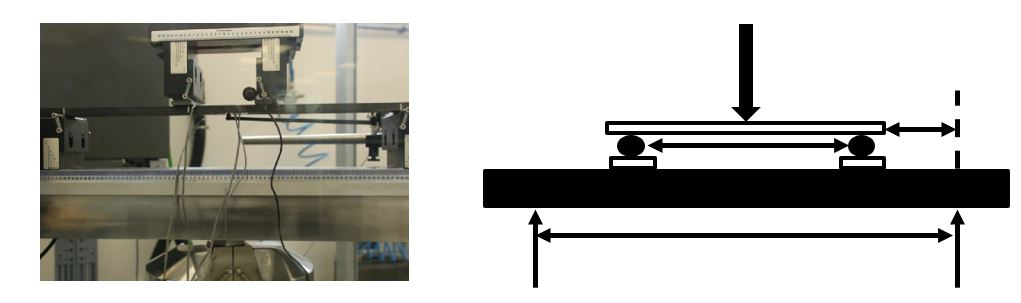

# Assumptions and Guidelines 

Ply thickness?
Ply Oreintation?
Distance of external rollers: At least 10% of coupon length should overhang on each end
Distance of internal rollers: Choose so that (LengthExtRoll-LengthIntRoll)/2 is atleast LengthExtRoll/4

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Material data

In [17]:
# APC2 PEEK
E11	= [144.0] # GPa
E22 = [9.5] # GPa
G12 = [5.1] # GPa
NU12 = [0.3]
PlyThick = [0.135] # mm
XT = [2200.0] # MPa
XC = [1250.0] # MPa
YT = [87.0] # MPa
YC = [215.0] # MPa
S12 = [190.0] # MPa
ST = [50.0] # MPa

# GFRP
E11.append(25.0) # GPa
E22.append(25.0) # GPa
G12.append(4.0) # GPa
NU12.append(0.2)
PlyThick.append(0.1) #in mm
XT.append(440.0) # MPa
XC.append(425.0) # MPa
YT.append(440.0) # MPa
YC.append(425.0) # MPa
S12.append(40.0) # MPa
ST.append(40.0) # MPa

## Laminate stacking sequence
Sequency = [0]
Mat_sequency = [0]
Repeat = 15
Sym = 0
Symc = 0

## Test data
CouponLength = 200.0 # mm
CouponWidth = 40.0 # mm
LengthExtRoll = (CouponLength)-(2*0.1*CouponLength) #in mm [At least 10% of coupon length should overhang on each end]
LengthIntRoll = LengthExtRoll/2 # mm [So that (LengthExtRoll-LengthIntRoll)/2 is atleast LengthExtRoll/4]
d1 = (LengthExtRoll-LengthIntRoll)*0.5 #in mm
# d1 = 300.0+25.0 #in mm
# LengthExtRoll = LengthIntRoll+2*d1 #in mm

## Code parameters
LaunchP = 1 #in N
alpha = 0.5
max_iter = 20

# Do Not Modify This Section

In [16]:
################## SPECIFIC FUNCTIONS ##################

def TMat(alpha):
    T = np.array([[np.cos(alpha)**2, np.sin(alpha)**2, 
                   np.sin(alpha)*np.cos(alpha)], 
                  [np.sin(alpha)**2, np.cos(alpha)**2, 
                   -np.sin(alpha)*np.cos(alpha)], 
                  [-2*np.sin(alpha)*np.cos(alpha), 
                   2*np.sin(alpha)*np.cos(alpha), 
                   np.cos(alpha)**2-np.sin(alpha)**2]])
    return T

def Bend(LaunchP):
    delta1 = np.sum(EQE1*np.diff(hk, axis = 0))
    delta2 = np.sum(EQE1*np.diff(1/2*(hk**2), axis = 0))
    delta3 = np.sum(EQE1*np.diff(1/3*(hk**3), axis = 0))
    epsmax = -LaunchP*LengthA*(Thickness/2)/(CouponWidth*(delta3-(delta2**2)/delta1)) #in mm/mm
    eps0 = -epsmax/(Thickness/2)*delta2/delta1 #in mm/mm
    sig = np.zeros((LengthStack*2, 1))
    eps = np.zeros((LengthStack*2, 1))
    posz = np.zeros((LengthStack*2, 1))
    fcritv = np.zeros((LengthStack, 5))
    for k in range(LengthStack): 
        Mat = MatSeq[k]
        eps[(2*k):(2*k+2)] = (eps0+np.array([hk[k],hk[k+1]])*epsmax/(Thickness/2))
        sig0 = EQE1[k]*(eps0+np.array([hk[k],hk[k+1]])*epsmax/(Thickness/2)) #in MPa
        sig[(2*k):(2*k+2)] = sig0
        posz[(2*k):(2*k+2)] = [hk[k],hk[k+1]]
        if StackSeq[k] == 0:
            fcritv[k,0] = np.max(sig0)/XT[Mat]
            fcritv[k,1] = -np.min(sig0)/XC[Mat]
        elif np.abs(StackSeq[k]) == 45: 
            fcritv[k,2] = np.max(np.abs(sig0))/S12[Mat]
        elif StackSeq[k] == 90:
            fcritv[k,3] = np.max(sig0)/YT[Mat]
            fcritv[k,4] = -np.min(sig0)/YC[Mat] 
    return fcritv, sig, posz, eps

def AMat(Df, Dg, Dm): 
    A = np.zeros((3,3))
    Qt = np.zeros((3, 3, LengthStack))
    EQE1 = np.zeros((LengthStack,1))
    EQEI = np.zeros((LengthStack,1))
    hk = np.zeros((LengthStack+1,1))
    hk[0] = -Thickness/2
    for k in range(1, LengthStack+1): 
        hk[k] = hk[0]+sum(PlyV[0:k])
    for k in range(LengthStack): 
        Mat = MatSeq[k]
        S = np.array([[1/(Df[k][0]*E11[Mat]), -Dm[k][0]*NU12[Mat]/E11[Mat], 0], 
                      [-Dm[k][0]*NU12[Mat]/E11[Mat], 1/(Dm[k][0]*E22[Mat]),0], 
                      [0, 0, 1/(Dg[k][0]*Dm[k][0]*Df[k][0]*G12[Mat])]])/1000
        T = TMat(np.deg2rad(StackSeq[k])) 
        Qt[:,:,k] = np.matmul(np.matmul(np.transpose(T), 
                        np.linalg.inv(S)), T)    
        A = A+Qt[:,:,k]*(hk[k+1]-hk[k])
        Qti = np.linalg.inv(Qt[:,:,k])
        EQE1[k] = 1/Qti[0,0]
        I = CouponWidth*PlyV[k]*(1/12*PlyV[k]**2 + (hk[k]+PlyV[k]/2)**2)
        EQEI[k] = EQE1[k]*I
    Ai = np.linalg.inv(A)
    E11L = 1/(Ai[0,0]*Thickness)
    EI = sum(EQEI)
    return hk, A, EQE1, Ai, E11L, EI

################## LAMINATE ##################
StackSeq = []
MatSeq = []
for k in range(Repeat): 
    StackSeq.append(Sequency)
    MatSeq.append(Mat_sequency)
if Sym == 1:
    Add = np.fliplr(StackSeq)
    StackSeq.append([item for sublist in Add for item in sublist])
    Add = np.fliplr(MatSeq)
    MatSeq.append([item for sublist in Add for item in sublist])
elif Symc == 1:
    Add = np.fliplr(StackSeq)[0:-1]
    StackSeq.append([item for sublist in Add for item in sublist])
    Add = np.fliplr(MatSeq)[0:-1]
    StackSeq.append([item for sublist in Add for item in sublist])
StackSeq = [item for sublist in StackSeq for item in sublist]
MatSeq = [item for sublist in MatSeq for item in sublist]
LengthStack = len(StackSeq)
PlyV = []
for i in range(LengthStack): 
    PlyV.append(PlyThick[MatSeq[i]])
Thickness = sum(PlyV)
LengthA = (LengthExtRoll-LengthIntRoll)/2

################## FAILURE MATRICES ##################
Df = np.zeros((LengthStack,1))+1.0
Dg = np.zeros((LengthStack,1))+1.0
Dm = np.zeros((LengthStack,1))+1.0
Fail = []
kcrit = 10
it = 1

################## STRAINS AND FAILURE CALCULATION ##################
while kcrit != 0 and kcrit != 1 and it <= max_iter:
    hk, A, EQE1, Ai, E11L, EI = AMat(Df, Dg, Dm)
    fcritv, sig, posz, eps = Bend(LaunchP)
    fcrit0 = np.max(fcritv, axis = -1)
    kcrit0 = np.argmax(fcritv, axis = -1)
    fcrit = np.max(fcrit0, axis = -1)
    kcritind = np.argmax(fcrit0, axis = -1)
    kcrit = kcrit0[kcritind]
    LaunchP = 1/fcrit*LaunchP
    fcritv, sig, posz, eps = Bend(LaunchP)
    MMax = LaunchP*LengthA #in N*mm
    dmax = MMax/(24*EI)*(3*LengthExtRoll**2-4*LengthA**2) #in mm
    if kcrit == 0 or kcrit == 1: 
        Df[kcritind] = alpha*Df[kcritind]
    elif kcrit == 2: 
        Dg[kcritind] = alpha*Dg[kcritind]
    elif kcrit == 3 or kcrit == 4:
        Dm[kcritind] = alpha*Dm[kcritind]
    Fail.append([kcritind+1, kcrit, round(2*LaunchP, 2)])
    it = it+1

# Results

Distance of external rollers = 160.0 mm
Distance of internal rollers = 80.0 mm
Applied force = 1.71 kN
Failure in ply 15 by longitudinal compression
Maximum displacement = 25.15 mm
Interlaminar shear security factor = 3.16


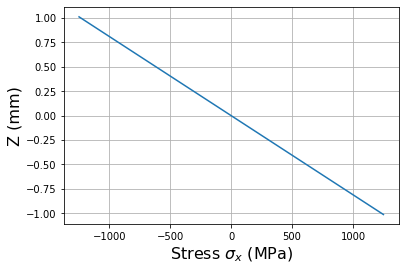

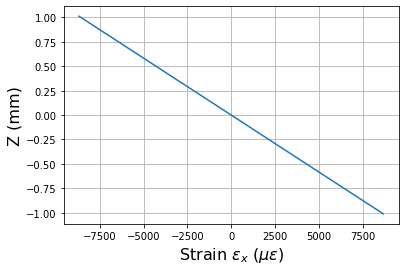

In [12]:
print('Distance of external rollers =',round(LengthExtRoll, 0),'mm')
print('Distance of internal rollers =',round(LengthIntRoll, 0),'mm')
print('Applied force =',round(2*LaunchP/1000, 2),'kN')
if kcrit == 0:
    print('Failure in ply',kcritind+1,'by longitudinal traction')
elif kcrit == 1: 
    print('Failure in ply',kcritind+1,'by longitudinal compression')
elif kcrit == 2:
    print('Failure in ply',kcritind+1,'by in-ply shear')
elif kcrit == 3:
    print('Failure in ply',kcritind+1,'by transverse traction')
elif kcrit == 4:
    print('Failure in ply',kcritind+1,'by transverse compression')
print('Maximum displacement =',round(dmax[0], 2),'mm')
TauMax = 3*2*LaunchP/(4*CouponWidth*Thickness)
print('Interlaminar shear security factor =',round(ST[0]/TauMax, 2))

plt.figure()
plt.plot(sig,posz)
plt.grid('True')
plt.xlabel('Stress $\sigma_x$ (MPa)', fontsize = 16)
plt.ylabel('Z (mm)', fontsize = 16)
plt.savefig('Stress.png', dpi = 300) 

plt.figure()
plt.plot(eps*1e6,posz)
plt.grid('True')
plt.xlabel('Strain $\epsilon_x$ ($\mu \epsilon$)', fontsize = 16)
plt.ylabel('Z (mm)', fontsize = 16)
plt.savefig('Strain.png', dpi = 300)